# VAE Image generation

Cassandra Maldonado

In [26]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [29]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

AttributeError: module 'keras.src.activations' has no attribute 'get'

In [30]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 * 50 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((50, 50, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

AttributeError: module 'keras.src.activations' has no attribute 'get'

In [48]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 1. Train VAE. Fit the VAE model using one of the 2 pictures, call it pic_1.

### Trim the picture to fit the input 200-by-200 dimensions using.

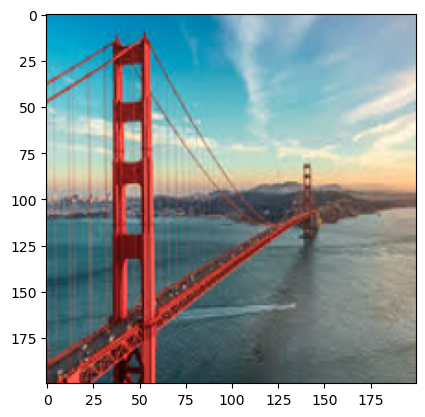

In [49]:
from PIL import Image

pic_1 = Image.open("pic_1.jpeg").convert("RGB")

pic_1 = pic_1.resize((220, 202))
pic_1 = np.array(pic_1)

pic_1 = np.expand_dims(pic_1, 0).astype("float32") / 255
pic_1 = pic_1[:,-201:-1, 0:200]

plt.imshow(pic_1[0])

In [50]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pic_1, epochs=100, batch_size=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - kl_loss: 0.0157 - loss: 27725.5000 - reconstruction_loss: 27725.4844
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 36.4894 - loss: 27742.1348 - reconstruction_loss: 27705.6445
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 1.4741 - loss: 27705.1172 - reconstruction_loss: 27703.6426
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 3.7253e-06 - loss: 27703.6289 - reconstruction_loss: 27703.6289
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - kl_loss: 5.6028e-06 - loss: 27679.4766 - reconstruction_loss: 27679.4766
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 8.4043e-06 - loss: 27673.7578 - reconstruction_loss: 27673.7578
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - kl_loss: 1.2726e-05 - loss: 27601.4102 - reconstruction_loss: 27601.4102
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - kl_loss: 2.5809e-05 - loss: 27599.9922 - reconstruction_loss: 27599.9922
Epoch 9/10

### 2. Sample the latent space. Explain the code in the Sampling function (copied below).

In [51]:
z_mean, z_log_var = inputs
batch = tf.shape(z_mean)[0]
dim = tf.shape(z_mean)[1]
epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#Line by line:

NameError: name 'inputs' is not defined